# Sudoku Puzzle Recognition

First attempt of this task, I am trying to make a model that recognize the numbers on a sudoku puzzle.

## Packages

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import os

## Dataset

Defining a pytorch custom dataset loader to load data in a more systematically way that helps to standardize the size of each images and the type.

The dataset is taken from the [Sudoku Dataset](https://github.com/wichtounet/sudoku_dataset), it has 200 sudoku puzzle images (160 for training and another 40 for testing).

Additionally, an image preprocessor is added to training and test dataset to make sure the size and scale are standardized. For training dataset, a data augmenter is also added for the purpose of randomizing different properties of the image (in a appropriate way) to give the neural network an illusion of having many different images.

In [2]:
# Custom Dataset Loader
class SudokuDataset(Dataset):
    def __init__(self, dir, list_path, transform=None, augmentation=None, target_transform=None):
        self.dir = dir
        self.filenames = self.extract_filenames(list_path)
        self.transform = transform
        self.augmentation = augmentation
        self.target_transform = target_transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        path = os.path.join(self.dir, self.filenames[idx])
        img = read_image(path+'.jpg')
        with open(path+'.dat', 'r') as file:
            label = file.readlines()

        label = [list(map(lambda i: int(i), i.split())) for i in label[2:]]
        
        if self.transform:
            img = self.transform(img)
        
        if self.augmentation:
            img = self.augmentation(img)

        if self.target_transform:
            label = self.target_transform(label)

        label=torch.tensor(label)
        
        return img, label

    def extract_filenames(self, list_path):
        with open(list_path, 'r') as file:
            img_list = file.readlines()
        return [i[:-5] for i in img_list]

# Basic Preprocessor
transforms = v2.Compose([
    v2.Resize(size=(400, 400)),
    v2.ToDtype(torch.float32, scale=True)
])

# Data Augmenter
augmentation = v2.Compose([
    # v2.RandomRotation(degrees=(0, 20)),
    v2.ColorJitter(brightness=.5, hue=.5),
    v2.RandomPosterize(bits=6),
    v2.RandomAdjustSharpness(sharpness_factor=2),
    v2.RandomAutocontrast(p=0.2)
])

In [3]:
training_data = SudokuDataset('./sudoku_dataset/', './sudoku_dataset/datasets/v2_mixed_train.desc', transforms, augmentation)
test_data = SudokuDataset('./sudoku_dataset/', './sudoku_dataset/datasets/v2_mixed_test.desc', transforms)

train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

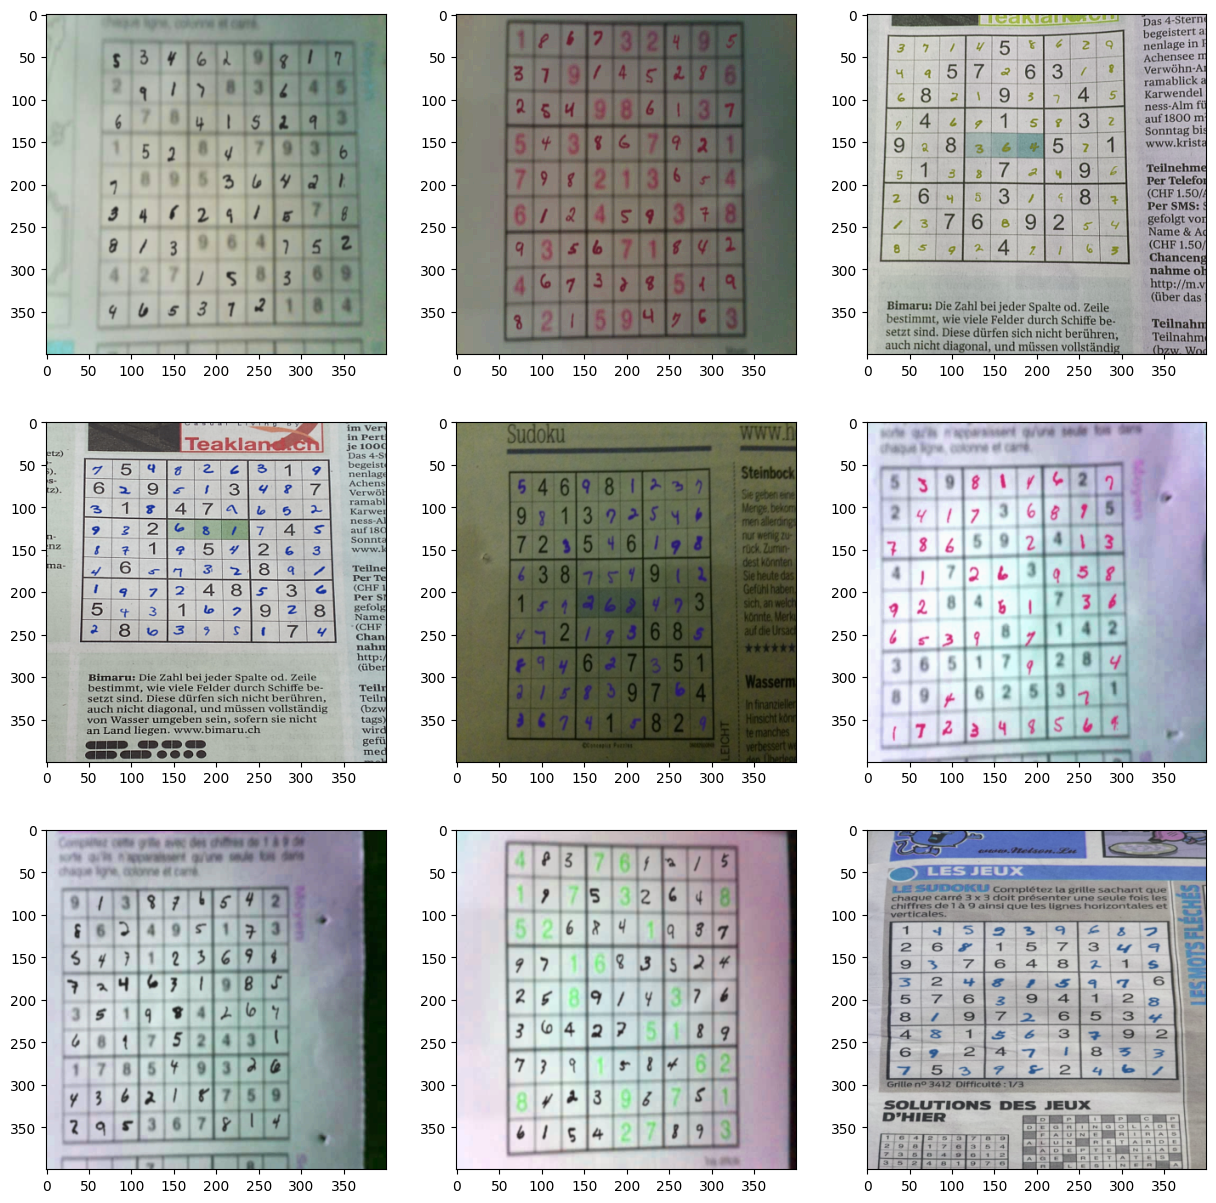

In [4]:
train_features, train_labels = next(iter(train_dataloader))

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Loop through images and display them in subplots
cnt = 0
for idx, axs in enumerate(axes):
    for ax in axs:
        ax.imshow(train_features[cnt].permute(1, 2, 0))
        cnt += 1
        

## Modelling

The plan is to experiment with different CNN architectures and see which one performs the best.

1. CNN 1

In [5]:
# Straightforward CNN

class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding='same')
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(8, 16, 3, padding='same')
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        self.conv3 = nn.Conv2d(16, 32, 3, padding='same')
        torch.nn.init.kaiming_normal_(self.conv3.weight)
        self.conv4 = nn.Conv2d(32, 16, 1, padding='same')
        torch.nn.init.kaiming_normal_(self.conv4.weight)
        self.conv5 = nn.Conv2d(16, 8, 1, padding='same')
        torch.nn.init.kaiming_normal_(self.conv5.weight)
        self.conv6 = nn.Conv2d(8, 1, 1, padding='same')
        torch.nn.init.kaiming_normal_(self.conv6.weight)
        self.fc1 = nn.Linear(2500, 1250)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(1250, 810)
        self.pool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # c1 -> P -> c2 -> P -> c3 -> P -> c4 -> c5 -> c6 -> flatten -> fc1 -> fc2 -> fc3 -> softmax
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def cnn1_loss(pred, target):

    # Perform crossentropy loss on every 10 units batch
    loss_fn = nn.CrossEntropyLoss()

    loss = 0
    
    # For each example
    for i in range(len(pred)):
        loss += loss_fn(torch.reshape(pred[i], (81, 10)), torch.flatten(target[i]))

    return loss    

## Training

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [7]:
cnn1 = CNN1().to(device)
print(cnn1)

CNN1(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (conv5): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (conv6): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=2500, out_features=1250, bias=True)
  (fc2): Linear(in_features=1250, out_features=810, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (softmax): Softmax(dim=1)
)


In [8]:
ALPHA=0.0001
optimizer = torch.optim.Adam(cnn1.parameters(), lr=ALPHA)

def train_step(epoch_idx, model, loss_fn):
    for idx, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        pred = model(inputs)
        loss = loss_fn(pred, labels)
        loss.backward()
        optimizer.step()    
        optimizer.zero_grad()

    with torch.no_grad():
        running_loss = 0
        running_vloss = 0
        for idx, data in enumerate(train_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs)
            loss = loss_fn(pred, labels)
            running_loss += loss

        avg_loss = running_loss / (idx + 1)
        
        for idx, data in enumerate(test_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs)
            vloss = loss_fn(pred, labels)
            running_vloss += vloss
            
        avg_vloss = running_vloss / (idx + 1)
    
        print(f"Epoch {epoch_idx}:\nTraining Loss: {avg_loss}\nTest Loss: {avg_vloss}") 
        
    return avg_loss, avg_vloss

In [9]:
losses = []
vlosses = []

for i in range(100):
    loss, vloss = train_step(i, cnn1, cnn1_loss)
    losses.append(loss)
    vlosses.append(vlosses)

Epoch 0:
Training Loss: 35.071746826171875
Test Loss: 29.588293075561523
Epoch 1:
Training Loss: 33.65721893310547
Test Loss: 28.65874481201172
Epoch 2:
Training Loss: 33.02872085571289
Test Loss: 28.279449462890625
Epoch 3:
Training Loss: 32.90129089355469
Test Loss: 28.091766357421875
Epoch 4:
Training Loss: 32.82380294799805
Test Loss: 28.06049919128418
Epoch 5:
Training Loss: 32.674034118652344
Test Loss: 28.020633697509766
Epoch 6:
Training Loss: 32.66996383666992
Test Loss: 28.068649291992188
Epoch 7:
Training Loss: 32.599185943603516
Test Loss: 27.978313446044922
Epoch 8:
Training Loss: 32.54278564453125
Test Loss: 27.898391723632812
Epoch 9:
Training Loss: 32.5097541809082
Test Loss: 27.859294891357422
Epoch 10:
Training Loss: 32.37333297729492
Test Loss: 27.899229049682617
Epoch 11:
Training Loss: 32.45240783691406
Test Loss: 27.8104305267334
Epoch 12:
Training Loss: 32.32276916503906
Test Loss: 27.836132049560547
Epoch 13:
Training Loss: 32.2413444519043
Test Loss: 27.7669639

In [10]:
def convert_to_puzzle(pred):
    output = torch.reshape(pred, (-1, 81, 10))
    output = torch.argmax(output, dim=2)
    return output

tensor([[4, 7, 6, 5, 9, 8, 3, 1, 2],
        [8, 2, 1, 3, 4, 6, 9, 5, 7],
        [9, 5, 3, 2, 1, 7, 6, 8, 4],
        [1, 4, 9, 6, 8, 5, 7, 2, 3],
        [2, 6, 8, 1, 7, 3, 5, 4, 9],
        [7, 3, 5, 9, 2, 4, 1, 6, 8],
        [6, 8, 2, 7, 5, 9, 4, 3, 1],
        [5, 9, 4, 8, 3, 1, 2, 7, 6],
        [3, 1, 7, 4, 6, 2, 8, 9, 5]])


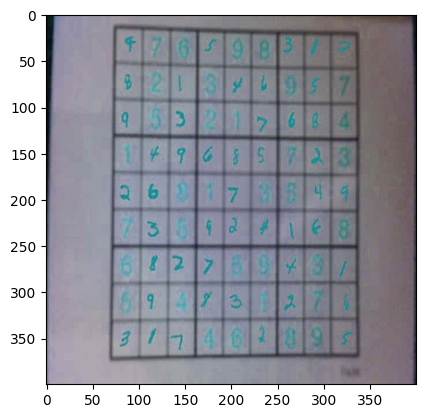

In [11]:
train_features, train_labels = next(iter(train_dataloader))

plt.imshow(train_features[0].permute(1, 2, 0))
print(train_labels[0])

In [12]:
x = convert_to_puzzle(cnn1(train_features.to('cuda')))
x = torch.reshape(x[0], (-1, 9, 9))
x == train_labels[0].to('cuda')

tensor([[[ True,  True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True],
         [ True, False,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True]]],
       device='cuda:0')

tensor([[3, 6, 1, 8, 2, 7, 9, 4, 5],
        [2, 5, 4, 3, 1, 9, 8, 7, 6],
        [8, 9, 7, 4, 6, 5, 3, 2, 1],
        [9, 2, 5, 6, 7, 1, 4, 3, 8],
        [1, 7, 8, 9, 4, 3, 5, 6, 2],
        [6, 4, 3, 5, 8, 2, 7, 1, 9],
        [4, 1, 9, 2, 3, 8, 6, 5, 7],
        [5, 3, 2, 7, 9, 6, 1, 8, 4],
        [7, 8, 6, 1, 5, 4, 2, 9, 3]])


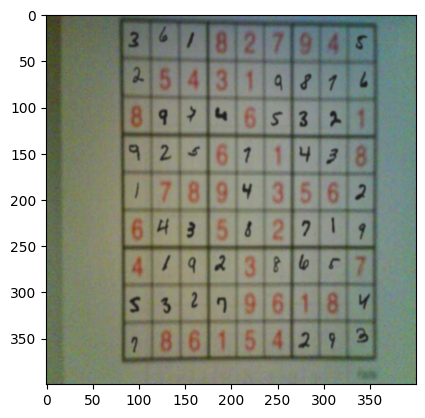

In [13]:
test_features, test_labels = next(iter(test_dataloader))

plt.imshow(test_features[0].permute(1, 2, 0))
print(test_labels[0])

In [14]:
x = convert_to_puzzle(cnn1(test_features.to('cuda')))
x = torch.reshape(x[0], (-1, 9, 9))
x == test_labels[0].to('cuda')

tensor([[[False, False, False, False, False, False,  True, False, False],
         [False, False, False, False, False,  True, False, False, False],
         [False, False, False, False,  True,  True,  True,  True, False],
         [False, False, False,  True, False, False, False, False, False],
         [False, False, False, False, False, False,  True, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False,  True, False],
         [False,  True, False, False, False,  True,  True,  True, False]]],
       device='cuda:0')

I gave up on this approach, because it seems kind of complicated for the neural network to learn.